Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

np.ones([1, 3])

array([[1., 1., 1.]])

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'
data_root = '/home/roman/data/' # Change me to store data elsewhere

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  dest = data_root + filename
  if not os.path.exists(dest):
    filename, _ = urlretrieve(url + filename, dest)
  statinfo = os.stat(dest)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % dest)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + dest + '. Can you get to it with a browser?')
  return dest

filename = maybe_download('text8.zip', 31344016)

Found and verified /home/roman/data/text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [12]:
vocabulary_size = 15000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary


data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5], len(dictionary))
print('Sample data', data[:10])
# del words  # Hint to reduce memory.
# data stores dense numbers in range [0, vocabulary_size)

Most common words (+UNK) [['UNK', 1270547], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)] 15000
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


In [13]:
#print(dictionary[:16])
#print(reverse_dictionary[:16])
print(data[:16])

[5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156, 128, 742, 477, 10572, 134, 1]


Function to generate a training batch for the skip-gram model.

In [18]:
data_index = 0

# num_skips - to how many words we will map the input word.
# Batch already contains the flattened output array by size num_skips (words)
# Therefore number of tranlsated words in the batch is batch_size/num_skips, each one of them 
# Translated to num_skips words.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
    print('    labels2:', labels)

data: ['UNK', 'UNK', 'as', 'a', 'term', 'of', 'UNK', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['UNK', 'UNK', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['UNK', 'as', 'a', 'UNK', 'as', 'term', 'of', 'a']
    labels2: [[  0]
 [ 12]
 [  6]
 [  0]
 [ 12]
 [195]
 [  2]
 [  6]]

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'term', 'UNK', 'UNK', 'UNK', 'of', 'term', 'as']
    labels2: [[  6]
 [195]
 [  0]
 [  0]
 [  0]
 [  2]
 [195]
 [ 12]]


In [6]:
# tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    ids = tf.constant([1,2, 0, 1], dtype=tf.int32)
    embeddings = tf.constant([[1, 2 ,3, 4], [5, 6, 7, 8], [9, 10, 11, 12]], dtype=tf.int32)
    embed = tf.nn.embedding_lookup(embeddings, ids)
    sess = tf.InteractiveSession(graph=graph)
    print(embed.eval())

[[ 5  6  7  8]
 [ 9 10 11 12]
 [ 1  2  3  4]
 [ 5  6  7  8]]


Train a skip-gram model.

In [16]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  # embeddings translate from vocabulary one-hot to embedded vector of smaller dimensionality
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  
  softmax_weights = tf.Variable(
    #  num_classes=vocabulary_size rows of len=embedding_size
    tf.truncated_normal([vocabulary_size, embedding_size],  
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs. uses ids from train_dataset to fetch rows from embeddings matrix.
  # Takes batch_size rows.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)  
  
  # Compute the softmax loss, using a sample of the negative labels each time.
  # The input to the network is the embedded vectors.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  
  # each row is of embedding_size is normalized vector describing the word
  # Embeddings has changed due to optimization.
  normalized_embeddings = embeddings / norm  
  
  # take random 16 rows for validation.
  valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
  print("Valid:", valid_embeddings)
  print("Normalized:",normalized_embeddings)

  # Takes subset of normalized_embeddings and multiplies by normalized_embeddings thus finds
  # similarity of that subset to all other words. Obviously at least one cell in similary matrix will be 1. 
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
  # Shape (16, vocabulary_size): i,j -> how much embedding[valid_dataset[i]] is similar to embedding[j]. 
  # Since valid_dataset is constant during learning we check the same 16 rows all the time.

Valid: Tensor("embedding_lookup_1:0", shape=(16, 128), dtype=float32, device=/device:CPU:0)
Normalized: Tensor("div:0", shape=(500, 128), dtype=float32, device=/device:CPU:0)


In [19]:
num_steps = 8001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        
        # Take similarity row i and find the indices with biggest cooficients
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 5.590304
Nearest to between: late, less, including, north, usually, produced, long, played,
Nearest to no: based, union, only, human, but, eight, terms, control,
Nearest to four: external, red, theory, though, much, possible, he, david,
Nearest to had: data, each, two, countries, land, if, public, down,
Nearest to more: term, social, where, german, state, number, different, does,
Nearest to may: support, international, does, groups, all, under, band, numbers,
Nearest to one: out, her, each, rights, single, life, f, or,
Nearest to see: common, left, service, court, william, other, band, much,
Nearest to this: at, view, down, science, up, according, europe, last,
Nearest to if: established, does, total, show, had, any, country, act,
Nearest to can: main, less, christian, is, itself, london, b, following,
Nearest to has: high, who, part, german, number, human, thus, them,
Nearest to united: created, g, place, far, once, when, different, do,
Nearest to a

In [ ]:
final_embeddings

In [20]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

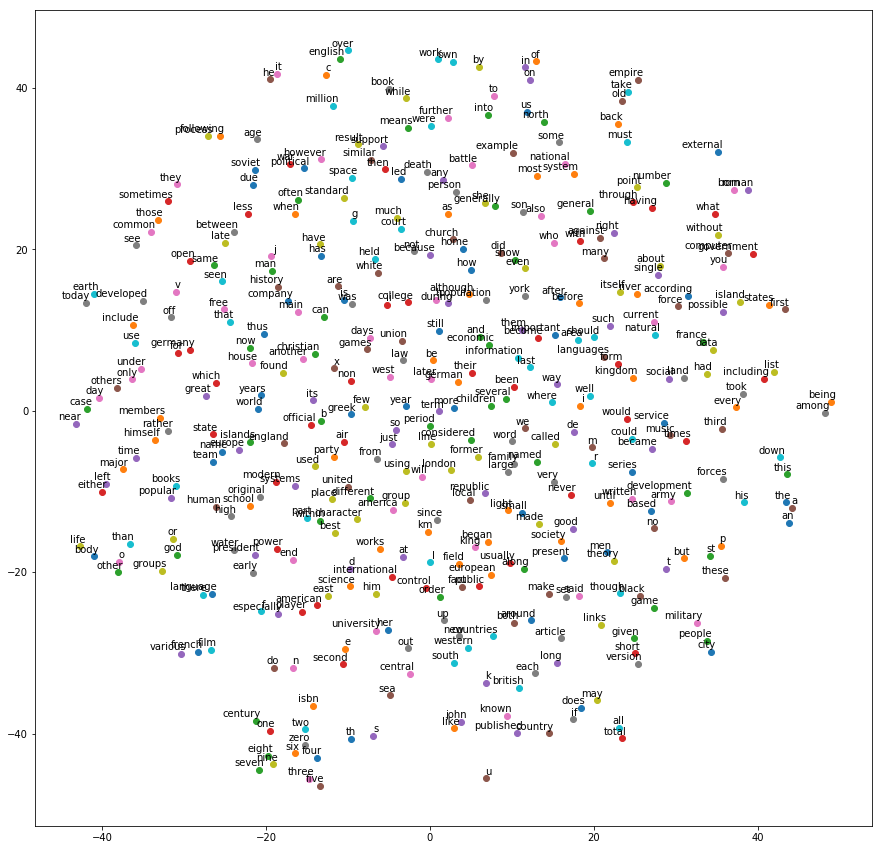

In [21]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

Check out: https://gist.github.com/yxtay/a94d971955d901c4690129580a4eafb9

---

In [16]:
data_index = 0

# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, context_window):
    # all context tokens should be used, hence no associated num_skips argument
    global data_index
    context_size = 2 * context_window
    batch = np.ndarray(shape=(batch_size, context_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * context_window + 1  # [ context_window target context_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size):
        # context tokens are just all the tokens in buffer except the target
        batch[i, :] = [token for idx, token in enumerate(buffer) if idx != context_window]
        labels[i, 0] = buffer[context_window]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels


batch, labels = generate_batch(batch_size=8, context_window=1)
for i in range(8):
    print(batch[i, 0], reverse_dictionary[batch[i, 0]],
          batch[i, 1], reverse_dictionary[batch[i, 1]],
          '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
context_window = 1  # How many words to consider left and right.
context_size = 2 * context_window

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64  # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():
    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size, context_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)
        # take mean of embeddings of context words for context embedding
        embed_context = tf.reduce_mean(embed, 1)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],
                                stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    nl = tf.nn.nce_loss(nce_weights, nce_biases, train_labels, embed_context, 
                        num_sampled, vocabulary_size)
    loss = tf.reduce_mean(nl)

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.AdagradOptimizer(0.5).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    print(normalized_embeddings)
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(
        valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.initialize_all_variables()

5239 anarchism 12 as -> 3084 originated
3084 originated 6 a -> 12 as
12 as 195 term -> 6 a
6 a 2 of -> 195 term
195 term 3137 abuse -> 2 of
2 of 46 first -> 3137 abuse
3137 abuse 59 used -> 46 first
46 first 156 against -> 59 used
Tensor("div:0", shape=(15000, 128), dtype=float32)


In [17]:
# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(
            batch_size, context_window)
        feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

        # We perform one update step by evaluating the optimizer op (including it
        # in the list of returned values for session.run()
        _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_val

        if step % 2000 == 0:
            if step > 0:
                average_loss /= 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print("Average loss at step ", step, ": ", average_loss)
            average_loss = 0

        # Note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log_str = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log_str = "%s %s," % (log_str, close_word)
                print(log_str)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  233.1820831298828
Nearest to also: lenses, asset, carolina, enter, kurt, criticism, maternal, monarchy,
Nearest to this: biomedical, annotated, sociology, disappointment, gutenberg, selection, mined, morgan,
Nearest to who: referred, inner, filmography, firing, trio, aires, questions, went,
Nearest to used: manager, quantity, blending, mrs, episode, gather, steam, championship,
Nearest to while: starch, violin, gi, wife, careers, her, joyce, logan,
Nearest to system: decreasing, skill, insurance, lab, bicameral, pornography, downstream, reach,
Nearest to seven: emitting, accessories, trace, referred, twentieth, normative, odysseus, judah,
Nearest to had: calgary, univ, dome, zhou, cuts, collective, pal, lc,
Nearest to may: neutrality, poseidon, colt, rid, targets, enables, hephaestus, amendments,
Nearest to are: byzantine, verification, dim, implementations, berry, thrace, hostages, cypriot,
Nearest to not: irving, hamsters, fender, yuri, breaking

Average loss at step  52000 :  4.013847470402718
Average loss at step  54000 :  3.989512775659561
Average loss at step  56000 :  4.0006054892539975
Average loss at step  58000 :  3.9222995629310606
Average loss at step  60000 :  3.968033595919609
Nearest to also: always, never, still, now, often, ever, lenses, asset,
Nearest to this: it, the, which, annotated, baptism, gutenberg, what, each,
Nearest to who: he, tax, which, they, alabama, she, referred, sheet,
Nearest to used: considered, designed, given, exercised, referred, known, weaver, classified,
Nearest to while: when, although, believes, before, after, where, traced, among,
Nearest to system: systems, glacial, decreasing, ptolemy, bicameral, insurance, strict, watterson,
Nearest to seven: five, eight, nine, six, four, zero, three, two,
Nearest to had: has, have, was, were, wrote, became, having, did,
Nearest to may: can, could, would, will, might, should, must, cannot,
Nearest to are: were, have, is, be, gcc, include, define, be

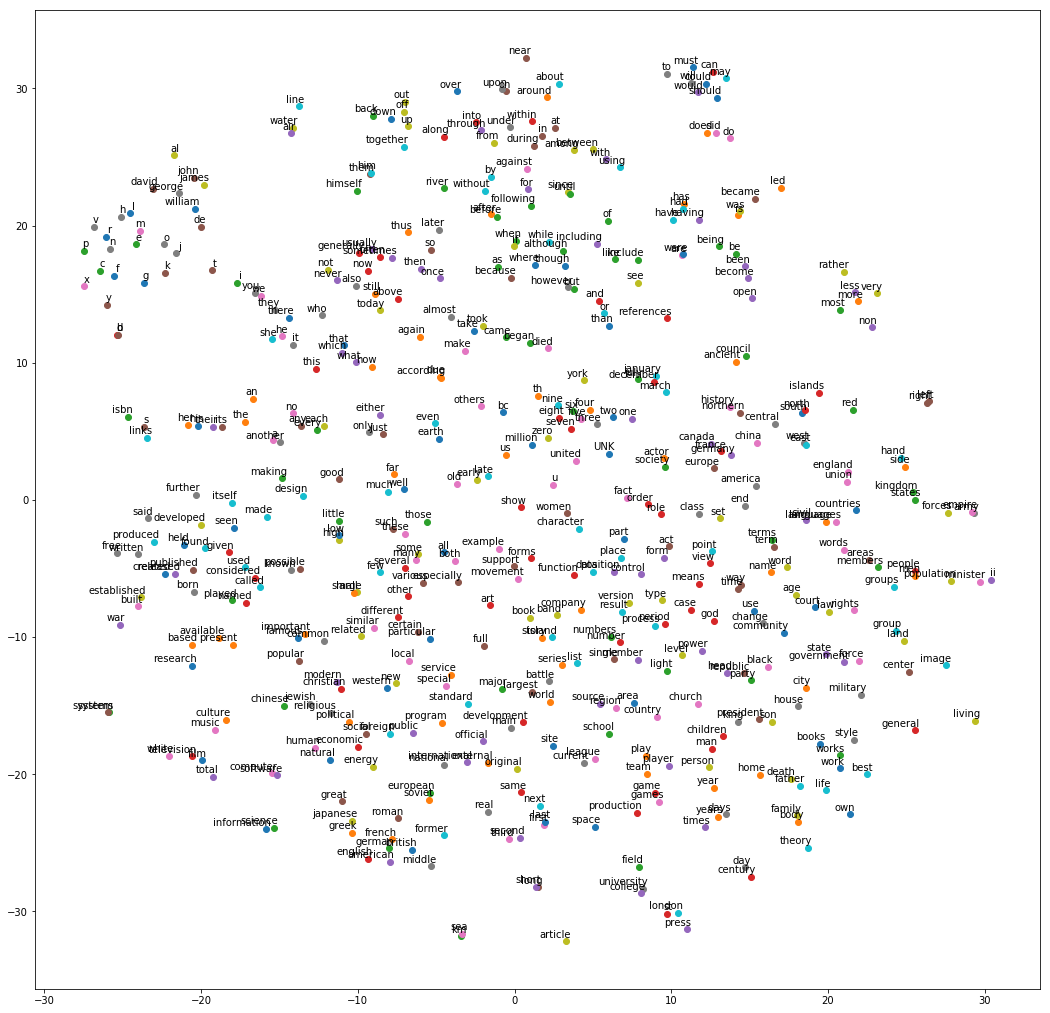

In [18]:
# Step 6: Visualize the embeddings.

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')

    plt.savefig(filename)


try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn and matplotlib to visualize embeddings.")